# Cerebellar volumetry analysis with GLM
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MAGeT (MDTB) atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus, cerebellar GM calculated from lobular volumes;
         - MAGeT: CrusI, CrusII,, WM, GM (adding all lobular volumes)
         - MBTB: MDTB functional regions 1,2,4,5 (deprecated);
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII;

## Cohorts
    - Current cohort: MNI ET/Augmented NC (34/177).

## Tasks: GLM analysis and permutation test for: 
    - Comparing cerebellar volumes (left/right GM/WM)
    - Compare lobular volumes ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII'; 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII'; 'Left_Dentate', 'Right_Dentate';];

## Covariates
- Age, Sex, intracranial volume (eTIV, cerebellar volume), site.

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import pandas as pd
import sys
sys.path.append('/codes')

data_dir = Path("/codes/tab_data")
# data files
matched_des_all_file = data_dir/ 'matched_Des-all_qced.csv'
matched_DKT_all_file = data_dir/ 'matched_DKT-all_qced.csv'
# readin data
matched_df = pd.read_csv(matched_DKT_all_file , sep=',', header=0, index_col=0);

In [2]:
# prepare data for this script
#SUIT
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
#MAGeT
MAGeT_l_labels = ['L_I_IV',  'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 
                 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X'];  # NO  'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'
MAGeT_r_labels = ['R_I_IV','R_V','R_VI','R_Crus_I','R_Crus_II',
                 'R_VIIB','R_VIIIA','R_VIIIB','R_IX','R_X'];  # NO  'Right_Dentate','Right_Interposed','Right_Fastigial'
#MDTB
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
general_info = ['age', 'sex', 'group', 'cohort', 'site', 'eTIV', 'is_adni', 'is_mni', 'is_ppmi', 'male', 'cerebellumVol', 'InfraTentorialVol']
freesurfer_cerebellar_list = ['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex'];
suit_lobular_list   = ['Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII', 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_Dentate', 'Right_Dentate'];
maget_lobular_list = ['L_Crus_I', 'R_Crus_I', 'L_Crus_II', 'R_Crus_II'];

# hypothesis testing 
ht_list = general_info + freesurfer_cerebellar_list + suit_lobular_list;
cerebellar_list_ordered =  ['Left_Cerebellar_GM', 'Right_Cerebellar_GM', 'Left_Cerebellar_WM', 'Right_Cerebellar_WM'];
ht_data_df  = matched_df.loc[:,ht_list].copy();
ht_data_df.columns=general_info + ['Left_Cerebellar_WM','Left_Cerebellar_GM','Right_Cerebellar_WM','Right_Cerebellar_GM'] + suit_lobular_list;
ht_tar_list = cerebellar_list_ordered + suit_lobular_list;
ht_mc=pd.DataFrame(zip(cerebellar_list_ordered+suit_lobular_list, len(cerebellar_list_ordered)*[len(cerebellar_list_ordered)]+len(suit_lobular_list)*[len(suit_lobular_list)]),
                   index=cerebellar_list_ordered+suit_lobular_list, columns=['ROI','n_comp']);

# SUIT hypothesis testing
suit_cerebellar_list= ['Left_cerebellar_GM_SUIT', 'Right_cerebellar_GM_SUIT'];
suit_cerebellar_list_ordered = ['Left_Cerebellar_GM', 'Right_Cerebellar_GM'];
ht_suit_list = general_info + suit_cerebellar_list + suit_lobular_list;
ht_suit_data_df  = matched_df.loc[:,ht_suit_list].copy();
ht_suit_data_df.columns = general_info + ['Left_Cerebellar_GM', 'Right_Cerebellar_GM'] + suit_lobular_list;
ht_suit_tar_list = suit_cerebellar_list_ordered + suit_lobular_list;
ht_suit_mc=pd.DataFrame(zip(suit_cerebellar_list_ordered+suit_lobular_list, len(suit_cerebellar_list_ordered)*[len(suit_cerebellar_list_ordered)]+len(suit_lobular_list)*[len(suit_lobular_list)]),
                        index=suit_cerebellar_list_ordered+suit_lobular_list, columns=['ROI','n_comp']);

# MAGeT hypothesis testing
maget_cerebellar_list= ['Left_cerebellar_GM_MAGeT', 'Right_cerebellar_GM_MAGeT', 'L_CM', 'R_CM'];
ht_maget_list = general_info + maget_cerebellar_list + maget_lobular_list;
ht_maget_tar_list = maget_cerebellar_list + maget_lobular_list;
ht_maget_data_df  = matched_df.loc[:,ht_maget_list].copy();
ht_maget_data_df.columns = general_info + ['Left_Cerebellar_GM', 'Right_Cerebellar_GM', 'Left_Cerebellar_WM', 'Right_Cerebellar_WM'] + maget_lobular_list;
ht_maget_tar_list = cerebellar_list_ordered + maget_lobular_list;
ht_maget_mc=pd.DataFrame(zip(cerebellar_list_ordered+maget_lobular_list, len(cerebellar_list_ordered)*[len(cerebellar_list_ordered)]+len(maget_lobular_list)*[len(maget_lobular_list)]),
                         index=cerebellar_list_ordered+maget_lobular_list, columns=['ROI','n_comp']);

# Hypothesis testing: 
## GLM analysis for matched dataset ET/NC (34/177) (QCed)
    1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

    2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate';

In [3]:
# Main hypothesis testing
# GLM for cerebellum volumetry before and after QC for MNI cohort controling difference intracranial volumes (age/sex/eTIV)
### statistical analysis
#import nipype.interfaces.io as nio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df  # private lib
# stats models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts

# basic settings
alpha_=0.05

tmp_df = ht_data_df.copy() 
print("Sample sizes for ET/NC: ")
print('\t',tmp_df[tmp_df['group']=='ET'].shape[0], ' / ',tmp_df[tmp_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(ht_tar_list))

print('\nGLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:\n')
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_etiv = glm_test(tmp_df, ht_tar_list, covariate_model_eTIV_str);
rep_model(covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("GLM for cerebellum volumetry (age/sex/cerebellumVol) on matched cohort:\n")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, ht_tar_list, covariate_model_cere_str);
rep_model(covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# with proportion correction in GLM
print("\n!!!!GLM for cerebellum volumetry (age/sex) with eTIV DPA on matched cohort:\n")
# 3.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
tmp_glmdpa_df = ht_data_df.copy()
for x_ in ht_suit_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df[x_]/tmp_glmdpa_df['eTIV']

dpa_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
dpaglm_dict_etiv = glm_test(tmp_glmdpa_df, ht_tar_list, dpa_model_eTIV_str);
rep_model(dpaglm_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 4. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\n!!!GLM for cerebellum volumetry (age/sex) with cerebellumVol DPA on matched cohort:\n")
tmp_glmdpa_df = ht_data_df.copy()
for x_ in ht_suit_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df.loc[:,x_]/tmp_glmdpa_df.loc[:,'cerebellumVol']
dpa_model_cere_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
dpaglm_dict_cere=glm_test(tmp_glmdpa_df, ht_tar_list, dpa_model_cere_str);
rep_model(dpaglm_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC: 
	 34  /  177
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_Cerebellar_WM, Right_Cerebellar_WM, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate

GLM for cerebellum volumetry (age/sex/eTIV) on matched cohort:

Left_Cerebellar_GM : no significant result with p= 0.7714805544801964
Right_Cerebellar_GM : no significant result with p= 0.8114724392745977
Left_Cerebellar_WM significant results detected without multiple comparison, detailed model report below:



Left_Cerebellar_WM~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC")) 

                                  Results: Generalized linear model
Model:                          GLM                          AIC:                      3788.5445     
Link Function:                  identity                     BIC:                      725822460.2987
Dependent Variable:  

##  Hypothesis testing with various confoudning effect model: noneparameric permutation test for matched dataset ET/NC (34/177) (QCed)
    1. Testing 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter' after controling for age, sex, eTIV/cerebellarVol/cohort ; 

    2. Testing 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate' controling for age, sex, eTIV/cerebellarVol/cohort;

In [4]:
# Main hypothesis testing with permutation test
# noneparametric permutation test
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es, creat_Bonf_df
#
alpha_=5; n_permu_=5000;
# 
sts_tests_list = ['Cohen_d']; 
group_mni_list = ['ET','NC'];

# for augmented dataset
def all_vol_stats(df_all, tar_list, alpha_, n_permu_, sts_tests_list):
    # Experiment 0: without controling for any covariates;
    res_cere_gw_all = cal_es(df_all, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
    # Experiment 1: control age/sex/eTIV with rm control group method;
    dat_cere_gw_all_1, cere_gw_all_col_1 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_1 = cal_es(dat_cere_gw_all_1, cere_gw_all_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
    res_cere_gw_all_1['ROI']=res_cere_gw_all_1['ROI'].map(lambda x: x[0:-37]);
    #Experiment 2: control age/sex/eTIV with direct proportion adjustment method;
    dat_cere_gw_all_2, cere_gw_all_col_2 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_2 = cal_es(dat_cere_gw_all_2, cere_gw_all_col_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
    res_cere_gw_all_2['ROI']=res_cere_gw_all_2['ROI'].map(lambda x: x[0:-36])
    #Experiment 3: control age/sex/eTIV with power proportion adjustment method;
    dat_cere_gw_all_3, cere_gw_all_col_3 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'ppa')
    res_cere_gw_all_3 = cal_es(dat_cere_gw_all_3, cere_gw_all_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"PPA with A,S,TIV");
    res_cere_gw_all_3['ROI']=res_cere_gw_all_3['ROI'].map(lambda x: x[0:-36])
    
    #Experiment 4: control age/sex/cerebellumVol with rm control group method;
    dat_cere_gw_all_4, cere_gw_col_all_4 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
    res_cere_gw_all_4 = cal_es(dat_cere_gw_all_4, cere_gw_col_all_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
    res_cere_gw_all_4['ROI']=res_cere_gw_all_4['ROI'].map(lambda x: x[0:-46]);
    #Experiment 5: control age/sex/cerebellumVol with direct proportion adjustment method;
    dat_cere_gw_all_5, cere_gw_all_col_5 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
    res_cere_gw_all_5 = cal_es(dat_cere_gw_all_5, cere_gw_all_col_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
    res_cere_gw_all_5['ROI']=res_cere_gw_all_5['ROI'].map(lambda x: x[0:-36]);
    #Experiment 6: control age/sex/cerebellumVol with power proportion adjustment method;
    dat_cere_gw_all_6, cere_gw_all_col_6 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'ppa')
    res_cere_gw_all_6 = cal_es(dat_cere_gw_all_6, cere_gw_all_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"PPA with A,S,Cere");
    res_cere_gw_all_6['ROI']=res_cere_gw_all_6['ROI'].map(lambda x: x[0:-36])
    
    res_method_all_df=pd.concat([res_cere_gw_all, res_cere_gw_all_1, res_cere_gw_all_2, res_cere_gw_all_3, res_cere_gw_all_4, res_cere_gw_all_5, res_cere_gw_all_6])
    return res_method_all_df

# Matched cohort after QC
tmp_df = ht_data_df.copy() 
print("Noneparametric-permutation tests with different confoudning effect control methods: ")
print("tested ROIs:")
print('\t',', '.join(ht_tar_list))
print('\n')
tmp_matched_data_df = ht_data_df.copy()
permu_es_df = all_vol_stats(tmp_matched_data_df, ht_tar_list, alpha_, n_permu_, sts_tests_list);

Noneparametric-permutation tests with different confoudning effect control methods: 
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_Cerebellar_WM, Right_Cerebellar_WM, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate


Using  rm_norm
New columns 13
Using  dpa
New columns 13
Using  ppa
New columns 13
Using  rm_norm
New columns 13
Using  dpa
New columns 13
Using  ppa
New columns 13


In [5]:
# Formating data structure: obtaining GLM effect size as cohen's d
def get_GLM_ES(tar_list, glm_res_dic, cov_, glm_str):
    res_df=pd.DataFrame(index=tar_list);
    res_df.loc[:,'ES'] = [glm_res_dic[x]['res'].tvalues[cov_] for x in tar_list];
    res_df.loc[:,'ROI'] = tar_list;
    res_df.loc[:,'group']='ET_NC';
    res_df.loc[:,'p_val'] = [glm_res_dic[x]['res'].pvalues[cov_] for x in tar_list];
    res_df.loc[:,'test'] = 'GLM_'+glm_str
    return res_df
glm_es_etiv_df=get_GLM_ES(ht_tar_list, covariate_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV')
glm_es_cere_df=get_GLM_ES(ht_tar_list, covariate_dict_cere, 'C(group, Treatment(reference="NC"))[T.ET]', 'cere')
glm_es_etiv_dpa_df=get_GLM_ES(ht_tar_list, dpaglm_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV_dpa')
glm_es_cere_dpa_df=get_GLM_ES(ht_tar_list, dpaglm_dict_cere,  'C(group, Treatment(reference="NC"))[T.ET]', 'cere_dpa')

glm_es_df=pd.concat([glm_es_etiv_df, glm_es_cere_df, glm_es_etiv_dpa_df, glm_es_cere_dpa_df])
# merge all es and p-vals
method_es_df =pd.concat([glm_es_df, permu_es_df])

Cerebellar ROI differences between ET and NC across confouding effect control methods in the augmented cohort.



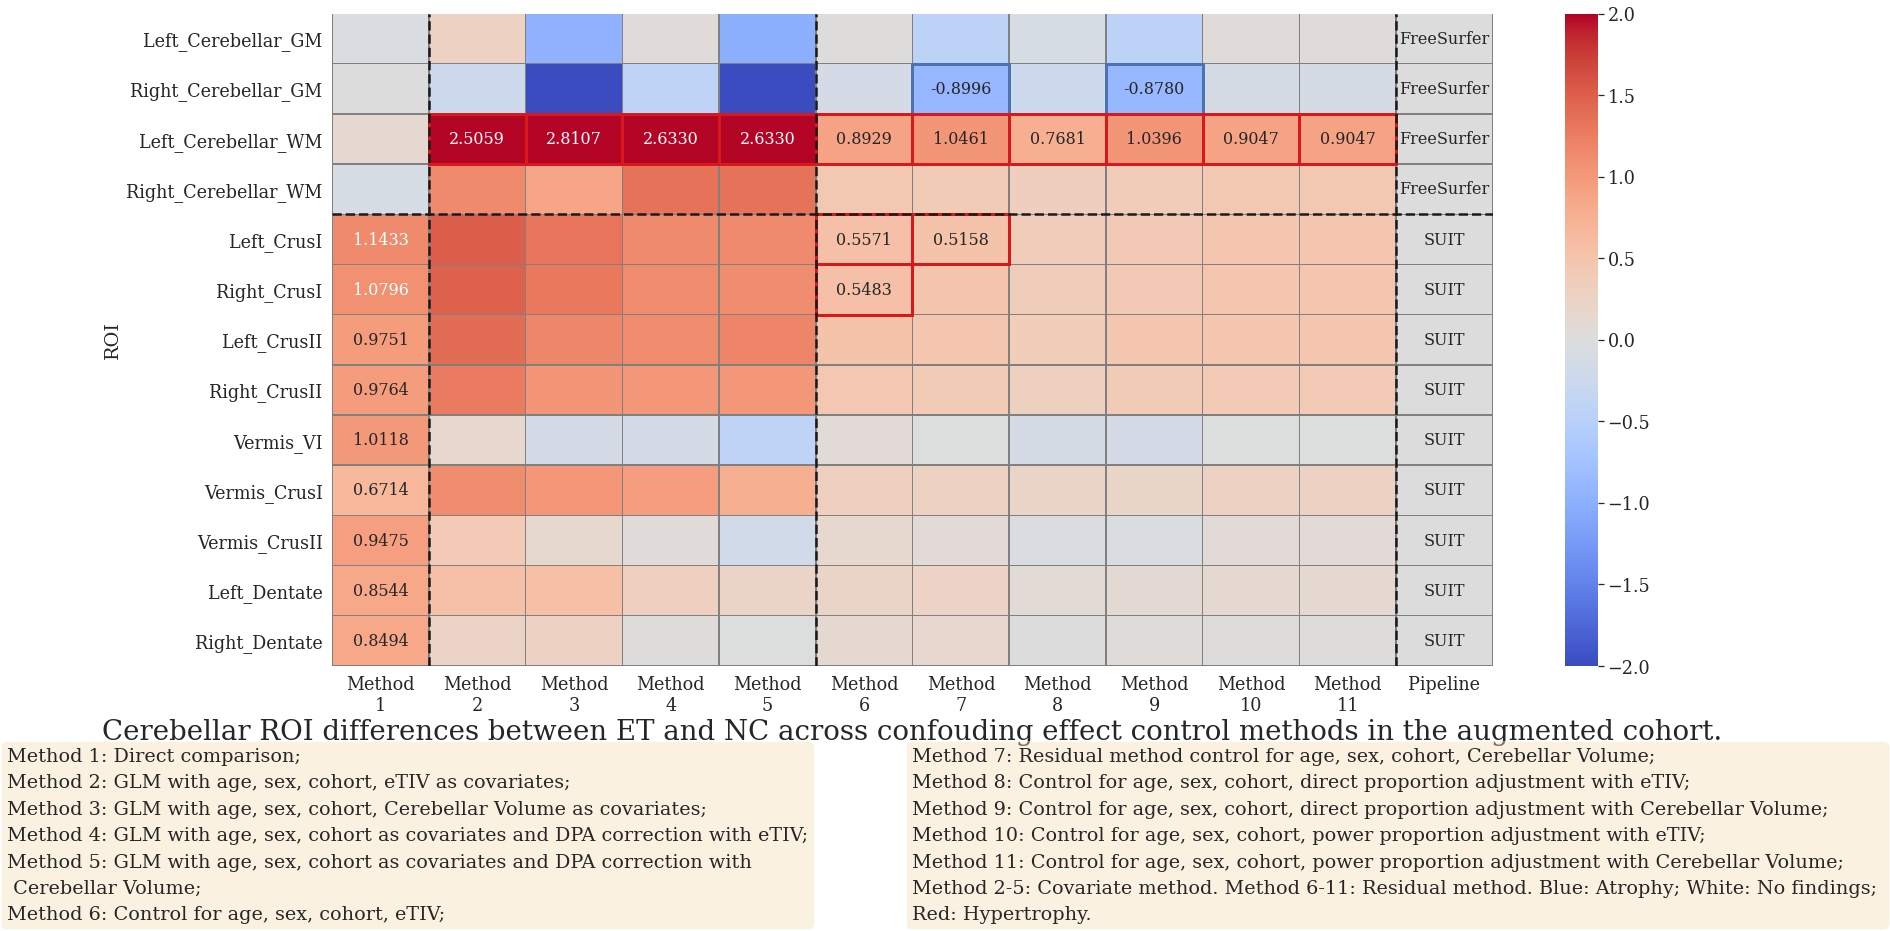

In [6]:
#  Main Figure 1 for S2 report:
# basic vis setting
figure_size=(26, 12);
legend_text_pos1=[-0.28, -0.125];
legend_text_pos2=[0.5, -0.125];
save_fig=0

legend_font_size='medium'
C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.6)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
# Preparing data
vis_df = method_es_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
order_list=['Cohen_d', 'GLM_eTIV', 'GLM_cere', 'GLM_eTIV_dpa', 'GLM_cere_dpa', 'Cohen_d_RN with A,S,TIV', 'Cohen_d_RN with A,S,Cere',
            'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,Cere', 'Cohen_d_PPA with A,S,TIV', 'Cohen_d_PPA with A,S,Cere']

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]
# reorder rows
es_df_=es_df_.reindex(ht_tar_list)
p_df_=p_df_.reindex(ht_tar_list)
# Multiple comparison correction
def f(x):
    if float(x)==0:
        return ""
    else:
        return "{:.4f}".format(x)
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, ht_mc)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)
xticklabels_str = [ 'Method\n'+str(x+1) for x in range(es_df_.shape[1])] +['Pipeline']
es_df_.loc[:,'Pipeline']  = len(ht_mc)*[0];
anno_df.loc[:,'Pipeline'] = len(freesurfer_cerebellar_list)*['FreeSurfer']+len(suit_lobular_list)*['SUIT'];

# vis
# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray') 
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str, annot_kws={'size':16},
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2, cbar_kws={"pad":0.05})

# xlabel
title_str='Cerebellar ROI differences between ET and NC across confouding effect control methods in the augmented cohort.\n'
ax2.set_xlabel(title_str, fontsize='x-large')
print(title_str)

# adding more repliccability information (need QC done)
from matplotlib.patches import Rectangle
lit_roi_all=[(6,1), (8,1)]
for x_ in lit_roi_all: ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

conflict_roi_all= [(x+1,2) for x in range(10)]+[(5,4),(5,5),(6,4)]
for x_ in conflict_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
h_line_pos=[4]; v_line_pos=[1,5,11];
for x in h_line_pos: plt.axhline(x, ls='--',c='k', lw=2.5)
for x in v_line_pos: plt.axvline(x, ls='--',c='k', lw=2.5)

## adding text boxes
textstr1 = '\n'.join([
    'Method 1: Direct comparison;',
    'Method 2: GLM with age, sex, cohort, eTIV as covariates;',
    'Method 3: GLM with age, sex, cohort, Cerebellar Volume as covariates;',
    'Method 4: GLM with age, sex, cohort as covariates and DPA correction with eTIV;',
    'Method 5: GLM with age, sex, cohort as covariates and DPA correction with\n Cerebellar Volume;',
    'Method 6: Control for age, sex, cohort, eTIV;'])
textstr2 = '\n'.join(['Method 7: Residual method control for age, sex, cohort, Cerebellar Volume;',
    'Method 8: Control for age, sex, cohort, direct proportion adjustment with eTIV;',
    'Method 9: Control for age, sex, cohort, direct proportion adjustment with Cerebellar Volume;',
    'Method 10: Control for age, sex, cohort, power proportion adjustment with eTIV;',
    'Method 11: Control for age, sex, cohort, power proportion adjustment with Cerebellar Volume;',
    'Method 2-5: Covariate method. Method 6-11: Residual method. Blue: Atrophy; White: No findings; \nRed: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos1[0], legend_text_pos1[1], textstr1, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
ax2.text(legend_text_pos2[0], legend_text_pos2[1], textstr2, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
if save_fig: print('saving...'); f2.savefig("Figure1_matched-corhorts_methods-Sensitivity.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [17]:
p_df_

p_val                                                \
test                Cohen_d  GLM_eTIV  GLM_cere GLM_eTIV_dpa GLM_cere_dpa   
ROI                                                                         
Left_Cerebellar_GM   0.4652  0.479990  0.936398     0.692936     0.907049   
Right_Cerebellar_GM  0.5016  0.888530  0.033336     0.717933     0.021475   
Left_Cerebellar_WM   0.0156  0.481359  0.733173     0.611434     0.833647   
Right_Cerebellar_WM  0.0040  0.654303  0.991269     0.778359     0.898511   
L_Crus_I             0.9096  0.165397  0.233329     0.235958     0.272215   
R_Crus_I             0.6244  0.750776  0.895936     0.849550     0.886494   
L_Crus_II            0.0012  0.958864  0.624952     0.950780     0.636824   
R_Crus_II            0.2748  0.968774  0.636966     0.984810     0.684968   

                                                                      \
test                Cohen_d_RN with A,S,TIV Cohen_d_RN with A,S,Cere   
ROI                                                                    
Left_Cerebellar_GM                   0.3660                   0.7276   
Right_Cerebellar_GM                  0.5400                   0.0000   
Left_Cerebellar_WM                   0.2052                   0.3012   
Right_Cerebellar_WM                  0.4196                   0.6836   
L_Crus_I                             0.0296                   0.0500   
R_Crus_I                             0.7636                   0.7548   
L_Crus_II                            0.9260                   0.3384   
R_Crus_II                            0.9728                   0.4868   

                                                                        \
test                Cohen_d_DPA with A,S,TIV Cohen_d_DPA with A,S,Cere   
ROI                                                                      
Left_Cerebellar_GM                    0.8940                    0.4740   
Right_Cerebellar_GM                   0.2060                    0.0000   
Left_Cerebellar_WM                    0.4012                    0.4424   
Right_Cerebellar_WM                   0.6816                    0.8796   
L_Crus_I                              0.1092                    0.0768   
R_Crus_I                              0.9452                    0.7308   
L_Crus_II                             0.6856                    0.3688   
R_Crus_II                             0.8904                    0.6000   

                                                                        
test                Cohen_d_PPA with A,S,TIV Cohen_d_PPA with A,S,Cere  
ROI                                                                     
Left_Cerebellar_GM                    0.2804                    0.2804  
Right_Cerebellar_GM                   0.5672                    0.5672  
Left_Cerebellar_WM                    0.1384                    0.1384  
Right_Cerebellar_WM                   0.3128                    0.3128  
L_Crus_I                              0.0216                    0.0216  
R_Crus_I                              0.6904                    0.6904  
L_Crus_II                             0.8716                    0.8716  
R_Crus_II                             0.8452                    0.8452

#  Methods sensitivity analysis (different cerebellar segmentations pipelines: SUIT and MAGeT): 
##  SUIT analysis for matched dataset ET/NC (34/177) (QCed)
    Similar tests except cerebellar whtie matter; 
##  MAGeT  analysis for matched dataset ET/NC (34/177) (QCed)
    Similar tests except vermis ROIs.

In [7]:
# GLM test for cerebellum volumetry of SUIT results (no cerebellar white matter)
### statistical analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df  # private lib
# stats models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts

# basic settings
alpha_=0.05

tmp_df = ht_suit_data_df.copy() 
print("Sample sizes for ET/NC SUIT ROI testing: ")
print('\t',tmp_df[tmp_df['group']=='ET'].shape[0], ' / ',tmp_df[tmp_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(ht_suit_tar_list))

print('\nGLM for cerebellar volumetry (age/sex/eTIV) on matched cohort:\n')
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
suit_covariate_dict_etiv = glm_test(tmp_df, ht_suit_tar_list, covariate_model_eTIV_str);
rep_model(suit_covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("GLM for cerebellar volumetry (age/sex/cerebellumVol) on matched cohort:\n")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
suit_covariate_dict_cere = glm_test(tmp_df, ht_suit_tar_list, covariate_model_cere_str);
rep_model(suit_covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# with proportion correction in GLM
print("\n!!!!GLM for cerebellar volumetry (age/sex) with eTIV DPA on matched cohort:\n")
# 3.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
tmp_glmdpa_df = ht_suit_data_df.copy()
for x_ in ht_suit_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df[x_]/tmp_glmdpa_df['eTIV']

dpa_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
suit_dpaglm_dict_etiv = glm_test(tmp_glmdpa_df, ht_suit_tar_list, dpa_model_eTIV_str);
rep_model(suit_dpaglm_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 4. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\n!!!GLM for cerebellar volumetry (age/sex) with cerebellumVol DPA on matched cohort:\n")
tmp_glmdpa_df = ht_suit_data_df.copy()
for x_ in ht_suit_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df.loc[:,x_]/tmp_glmdpa_df.loc[:,'cerebellumVol']
dpa_model_cere_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
suit_dpaglm_dict_cere=glm_test(tmp_glmdpa_df, ht_suit_tar_list, dpa_model_cere_str);
rep_model(suit_dpaglm_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC SUIT ROI testing: 
	 34  /  177
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate

GLM for cerebellar volumetry (age/sex/eTIV) on matched cohort:

Left_Cerebellar_GM : no significant result with p= 0.16703465362690506
Right_Cerebellar_GM : no significant result with p= 0.18368895869285073
Left_CrusI : no significant result with p= 0.13001640407923876
Right_CrusI : no significant result with p= 0.13735959915423387
Left_CrusII : no significant result with p= 0.1637369404756499
Right_CrusII : no significant result with p= 0.20084210129232183
Vermis_VI : no significant result with p= 0.8729462665603396
Vermis_CrusI : no significant result with p= 0.26669849255297495
Vermis_CrusII : no significant result with p= 0.6844674022834281
Left_Dentate : no significant result with p= 0.578342639351762
Right_Dentate : no significant result with p= 0.8120

In [8]:
# noneparametric permutation test for SUIT resutls
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es, creat_Bonf_df
#
alpha_=5; n_permu_=5000;
# 
sts_tests_list = ['Cohen_d']; 
group_mni_list = ['ET','NC'];

# Matched cohort after QC
tmp_df = ht_data_df.copy() 
print("Noneparametric-permutation tests with different confoudning effect control methods: ")
print("tested ROIs:")
print('\t',', '.join(ht_suit_tar_list))
print('\n')
tmp_suit_data_df = ht_suit_data_df.copy()
suit_permu_es_df = all_vol_stats(tmp_suit_data_df, ht_suit_tar_list, alpha_, n_permu_, sts_tests_list);

Noneparametric-permutation tests with different confoudning effect control methods: 
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_CrusI, Right_CrusI, Left_CrusII, Right_CrusII, Vermis_VI, Vermis_CrusI, Vermis_CrusII, Left_Dentate, Right_Dentate


Using  rm_norm
New columns 11
Using  dpa
New columns 11
Using  ppa
New columns 11
Using  rm_norm
New columns 11
Using  dpa
New columns 11
Using  ppa
New columns 11


In [9]:
# Formating data structure: obtaining GLM effect size as cohen's d for SUIT results.
def get_GLM_ES(tar_list, glm_res_dic, cov_, glm_str):
    res_df=pd.DataFrame(index=tar_list);
    res_df.loc[:,'ES'] = [glm_res_dic[x]['res'].tvalues[cov_] for x in tar_list];
    res_df.loc[:,'ROI'] = tar_list;
    res_df.loc[:,'group']='ET_NC';
    res_df.loc[:,'p_val'] = [glm_res_dic[x]['res'].pvalues[cov_] for x in tar_list];
    res_df.loc[:,'test'] = 'GLM_'+glm_str
    return res_df
suit_glm_es_etiv_df=get_GLM_ES(ht_suit_tar_list, suit_covariate_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV')
suit_glm_es_cere_df=get_GLM_ES(ht_suit_tar_list, suit_covariate_dict_cere, 'C(group, Treatment(reference="NC"))[T.ET]', 'cere')
suit_glm_es_etiv_dpa_df=get_GLM_ES(ht_suit_tar_list, suit_dpaglm_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV_dpa')
suit_glm_es_cere_dpa_df=get_GLM_ES(ht_suit_tar_list, suit_dpaglm_dict_cere,  'C(group, Treatment(reference="NC"))[T.ET]', 'cere_dpa')

suit_glm_es_df=pd.concat([suit_glm_es_etiv_df, suit_glm_es_cere_df, suit_glm_es_etiv_dpa_df, suit_glm_es_cere_dpa_df])
# merge all es and p-vals
suit_method_es_df =pd.concat([suit_glm_es_df, suit_permu_es_df])

Cerebellar ROI (SUIT) differences between ET and NC across confouding effect control methods in the augmented cohort.

saving...


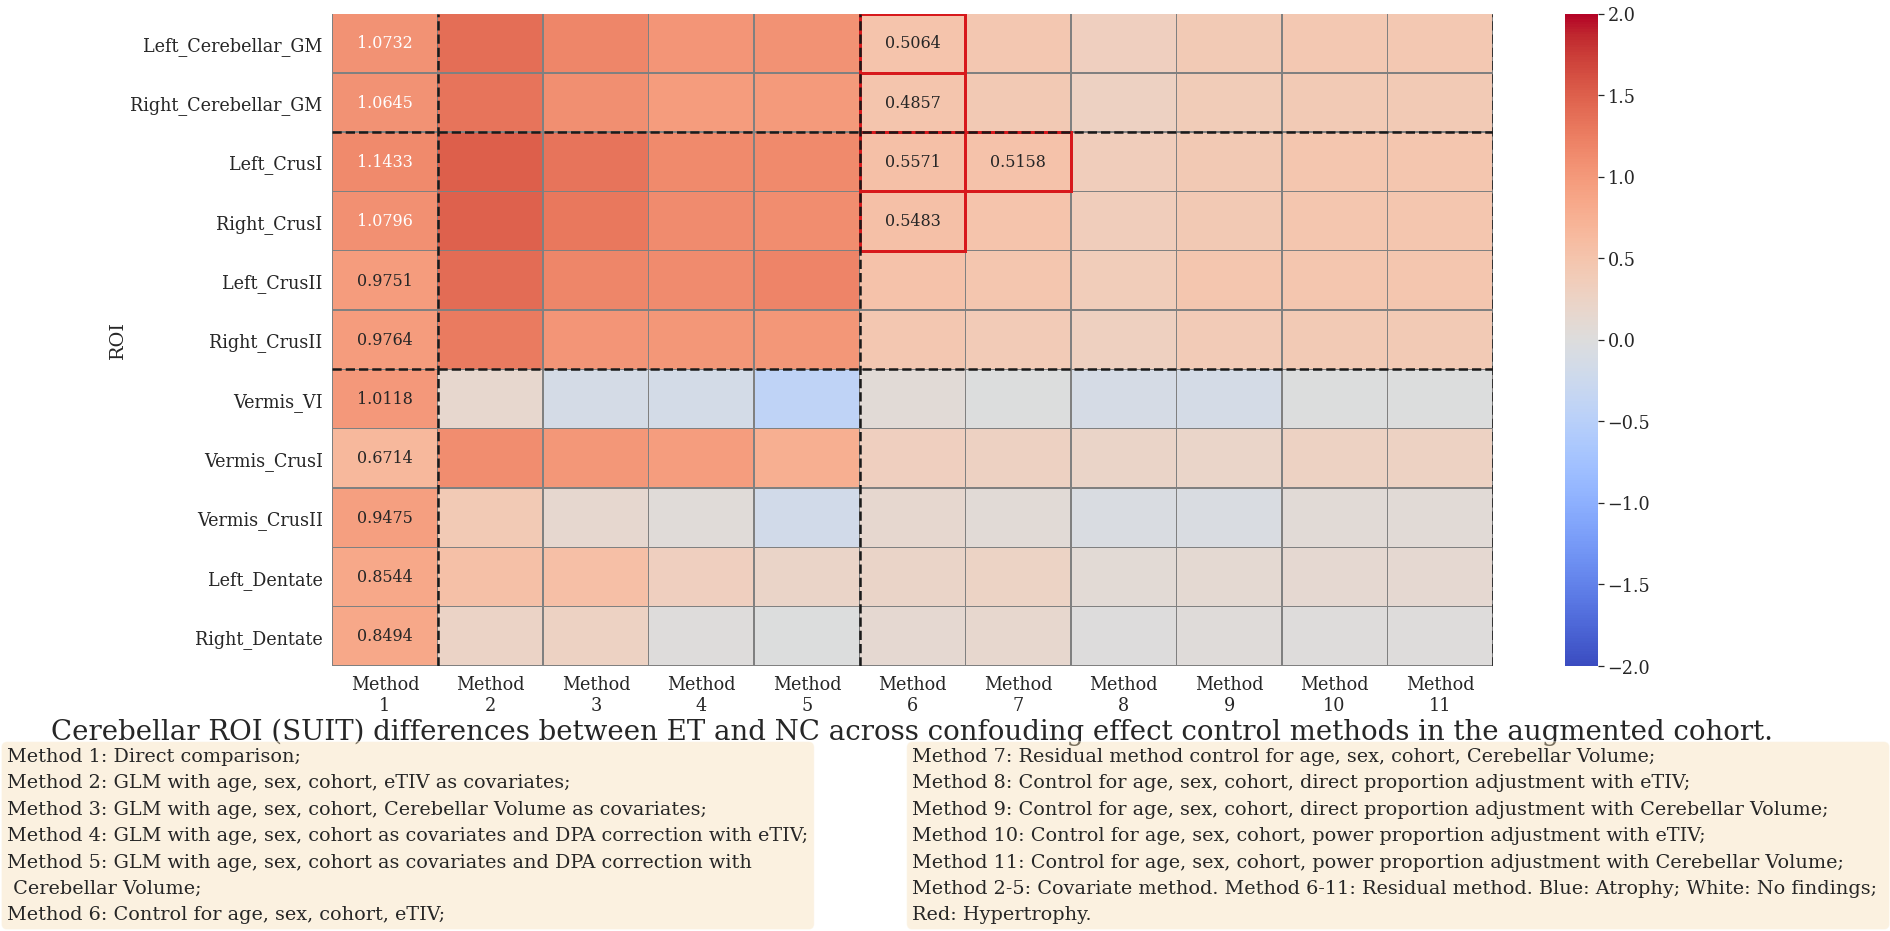

In [10]:
# Visualization of SUIT results hypothesis testing (no cerebellar White matter).
# basic vis setting
figure_size=(26, 12);
legend_text_pos1=[-0.28, -0.125];
legend_text_pos2=[0.5, -0.125];
save_fig=1

legend_font_size='medium'
C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.6)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Preparing data
vis_df = suit_method_es_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
order_list=['Cohen_d', 'GLM_eTIV', 'GLM_cere', 'GLM_eTIV_dpa', 'GLM_cere_dpa', 'Cohen_d_RN with A,S,TIV', 'Cohen_d_RN with A,S,Cere',
            'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,Cere', 'Cohen_d_PPA with A,S,TIV', 'Cohen_d_PPA with A,S,Cere']

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]
# reorder rows
es_df_=es_df_.reindex(ht_suit_tar_list)
p_df_=p_df_.reindex(ht_suit_tar_list)
# Multiple comparison correction
def f(x):
    if float(x)==0:
        return ""
    else:
        return "{:.4f}".format(x)
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, ht_mc)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)
xticklabels_str = [ 'Method\n'+str(x+1) for x in range(es_df_.shape[1])]

# vis
# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray') 
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str, annot_kws={'size':16},
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2, cbar_kws={"pad":0.05})

# xlabel
title_str='Cerebellar ROI (SUIT) differences between ET and NC across confouding effect control methods in the augmented cohort.\n'
ax2.set_xlabel(title_str, fontsize='x-large')
print(title_str)

# adding more repliccability information (need QC done)
from matplotlib.patches import Rectangle
#lit_roi_all=[(6,1), (8,1)]
#for x_ in lit_roi_all: ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))

conflict_roi_all= [(5,x) for x in range(4)]+[(6,2)]
for x_ in conflict_roi_all:
    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
h_line_pos=[2,6]; v_line_pos=[1,5,11];
for x in h_line_pos: plt.axhline(x, ls='--',c='k', lw=2.5)
for x in v_line_pos: plt.axvline(x, ls='--',c='k', lw=2.5)

## adding text boxes
textstr1 = '\n'.join([
    'Method 1: Direct comparison;',
    'Method 2: GLM with age, sex, cohort, eTIV as covariates;',
    'Method 3: GLM with age, sex, cohort, Cerebellar Volume as covariates;',
    'Method 4: GLM with age, sex, cohort as covariates and DPA correction with eTIV;',
    'Method 5: GLM with age, sex, cohort as covariates and DPA correction with\n Cerebellar Volume;',
    'Method 6: Control for age, sex, cohort, eTIV;'])
textstr2 = '\n'.join(['Method 7: Residual method control for age, sex, cohort, Cerebellar Volume;',
    'Method 8: Control for age, sex, cohort, direct proportion adjustment with eTIV;',
    'Method 9: Control for age, sex, cohort, direct proportion adjustment with Cerebellar Volume;',
    'Method 10: Control for age, sex, cohort, power proportion adjustment with eTIV;',
    'Method 11: Control for age, sex, cohort, power proportion adjustment with Cerebellar Volume;',
    'Method 2-5: Covariate method. Method 6-11: Residual method. Blue: Atrophy; White: No findings; \nRed: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos1[0], legend_text_pos1[1], textstr1, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
ax2.text(legend_text_pos2[0], legend_text_pos2[1], textstr2, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
if save_fig: print('saving...'); f2.savefig("Figure1_matched-corhorts_methods-Sensitivity_SUIT.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)# , dpi=300

In [11]:
# GLM for cerebellum volumetry of MAGeT results
### statistical analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df  # private lib
# stats models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts

# basic settings
alpha_=0.05

tmp_df = ht_maget_data_df.copy() 
print("Sample sizes for ET/NC SUIT ROI testing: ")
print('\t',tmp_df[tmp_df['group']=='ET'].shape[0], ' / ',tmp_df[tmp_df['group']=='NC'].shape[0])
print("tested ROIs:")
print('\t',', '.join(ht_maget_tar_list))

print('\nGLM for cerebellar volumetry (age/sex/eTIV) on matched cohort:\n')
# 1.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
covariate_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
maget_covariate_dict_etiv = glm_test(tmp_df, ht_maget_tar_list, covariate_model_eTIV_str);
rep_model(maget_covariate_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 2. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("GLM for cerebellar volumetry (age/sex/cerebellumVol) on matched cohort:\n")
covariate_model_cere_str = '~age+C(sex, Treatment(reference="F"))+cerebellumVol+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
maget_covariate_dict_cere = glm_test(tmp_df, ht_maget_tar_list, covariate_model_cere_str);
rep_model(maget_covariate_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# with proportion correction in GLM
print("\n!!!!GLM for cerebellar volumetry (age/sex) with eTIV DPA on matched cohort:\n")
# 3.GLM for cerebellum volumetry with covariates:  age/sex/cohort/group/eTIV
tmp_glmdpa_df = ht_maget_data_df.copy()
for x_ in ht_maget_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df[x_]/tmp_glmdpa_df['eTIV']

dpa_model_eTIV_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
maget_dpaglm_dict_etiv = glm_test(tmp_glmdpa_df, ht_maget_tar_list, dpa_model_eTIV_str);
rep_model(maget_dpaglm_dict_etiv, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});
print('\n')

# 4. GLM for cerebellum volumetry with covariates: age/sex/cohort/group/cerebellumVol.
print("\n!!!GLM for cerebellar volumetry (age/sex) with cerebellumVol DPA on matched cohort:\n")
tmp_glmdpa_df = ht_maget_data_df.copy()
for x_ in ht_maget_tar_list:
    tmp_glmdpa_df.loc[:,x_]=tmp_glmdpa_df.loc[:,x_]/tmp_glmdpa_df.loc[:,'cerebellumVol']
dpa_model_cere_str = '~age+C(sex, Treatment(reference="F"))+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
maget_dpaglm_dict_cere=glm_test(tmp_glmdpa_df, ht_maget_tar_list, dpa_model_cere_str);
rep_model(maget_dpaglm_dict_cere, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_});

Sample sizes for ET/NC SUIT ROI testing: 
	 34  /  177
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_Cerebellar_WM, Right_Cerebellar_WM, L_Crus_I, R_Crus_I, L_Crus_II, R_Crus_II

GLM for cerebellar volumetry (age/sex/eTIV) on matched cohort:

Left_Cerebellar_GM : no significant result with p= 0.4799902951771229
Right_Cerebellar_GM : no significant result with p= 0.8885296366125459
Left_Cerebellar_WM : no significant result with p= 0.48135874826968805
Right_Cerebellar_WM : no significant result with p= 0.6543027409273221
L_Crus_I : no significant result with p= 0.16539656754121856
R_Crus_I : no significant result with p= 0.7507758508649083
L_Crus_II : no significant result with p= 0.95886446868607
R_Crus_II : no significant result with p= 0.9687736616096736


GLM for cerebellar volumetry (age/sex/cerebellumVol) on matched cohort:

Left_Cerebellar_GM : no significant result with p= 0.9363975710872978
Right_Cerebellar_GM significant results detected without multiple compari

In [12]:
# noneparametric permutation test for MAGeT resutls
from utils_.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es, creat_Bonf_df
#
alpha_=5; n_permu_=5000;
# 
sts_tests_list = ['Cohen_d']; 
group_mni_list = ['ET','NC'];

# Matched cohort after QC
tmp_df = ht_data_df.copy() 
print("Noneparametric-permutation tests with different confoudning effect control methods: ")
print("tested ROIs:")
print('\t',', '.join(ht_maget_tar_list))
print('\n')
tmp_maget_data_df = ht_maget_data_df.copy()
maget_permu_es_df = all_vol_stats(tmp_maget_data_df, ht_maget_tar_list, alpha_, n_permu_, sts_tests_list);

Noneparametric-permutation tests with different confoudning effect control methods: 
tested ROIs:
	 Left_Cerebellar_GM, Right_Cerebellar_GM, Left_Cerebellar_WM, Right_Cerebellar_WM, L_Crus_I, R_Crus_I, L_Crus_II, R_Crus_II


Using  rm_norm
New columns 8
Using  dpa
New columns 8
Using  ppa
New columns 8
Using  rm_norm
New columns 8
Using  dpa
New columns 8
Using  ppa
New columns 8


In [13]:
# Formating data structure: obtaining GLM effect size as cohen's d for MAGeT results.
def get_GLM_ES(tar_list, glm_res_dic, cov_, glm_str):
    res_df=pd.DataFrame(index=tar_list);
    res_df.loc[:,'ES'] = [glm_res_dic[x]['res'].tvalues[cov_] for x in tar_list];
    res_df.loc[:,'ROI'] = tar_list;
    res_df.loc[:,'group']='ET_NC';
    res_df.loc[:,'p_val'] = [glm_res_dic[x]['res'].pvalues[cov_] for x in tar_list];
    res_df.loc[:,'test'] = 'GLM_'+glm_str
    return res_df
maget_glm_es_etiv_df=get_GLM_ES(ht_maget_tar_list, maget_covariate_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV')
maget_glm_es_cere_df=get_GLM_ES(ht_maget_tar_list, maget_covariate_dict_cere, 'C(group, Treatment(reference="NC"))[T.ET]', 'cere')
maget_glm_es_etiv_dpa_df=get_GLM_ES(ht_maget_tar_list, maget_dpaglm_dict_etiv, 'C(group, Treatment(reference="NC"))[T.ET]', 'eTIV_dpa')
maget_glm_es_cere_dpa_df=get_GLM_ES(ht_maget_tar_list, maget_dpaglm_dict_cere,  'C(group, Treatment(reference="NC"))[T.ET]', 'cere_dpa')

maget_glm_es_df=pd.concat([maget_glm_es_etiv_df, maget_glm_es_cere_df, maget_glm_es_etiv_dpa_df, maget_glm_es_cere_dpa_df])
# merge all es and p-vals
maget_method_es_df =pd.concat([maget_glm_es_df, maget_permu_es_df])

Cerebellar ROI (MAGeT) differences between ET and NC across confouding effect control methods in the augmented cohort.

saving...


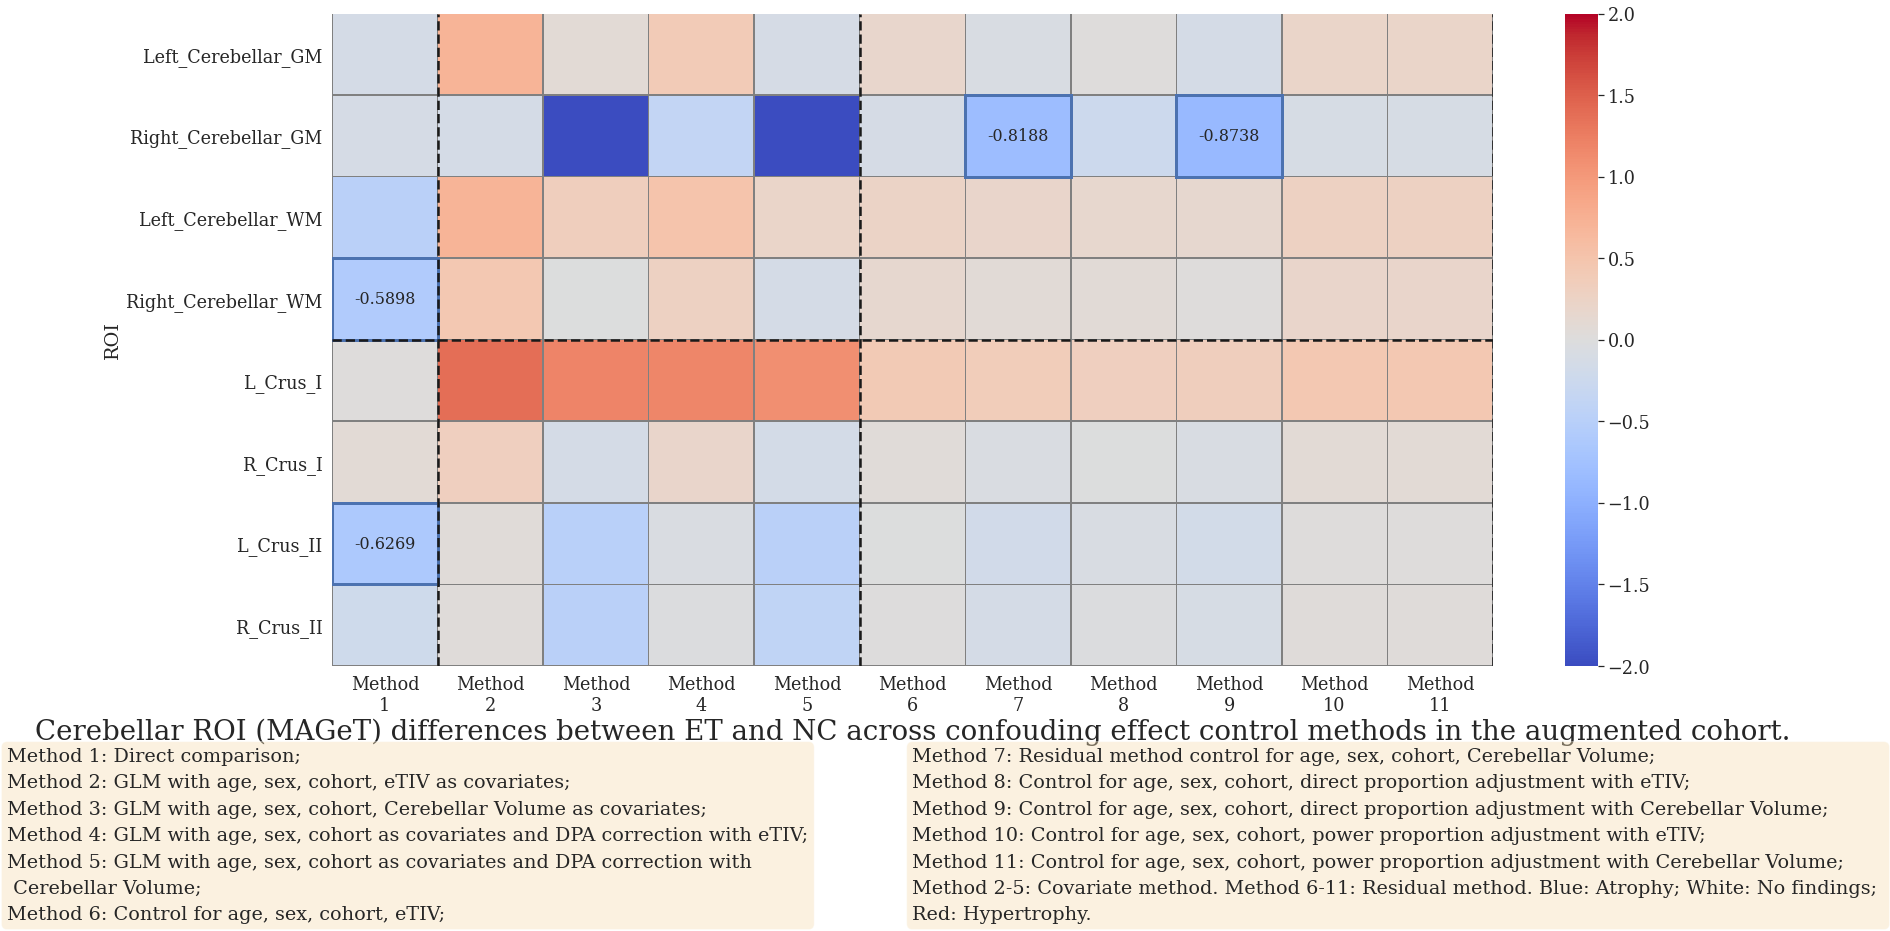

In [14]:
# Visualization of MAGeT results hypothesis testing (no vermis).
# basic vis setting
figure_size=(26, 12);
legend_text_pos1=[-0.28, -0.125];
legend_text_pos2=[0.5, -0.125];
save_fig=1

legend_font_size='medium'
C_MAP='coolwarm'; VMIN=-2; VMAX=2; alpha_=0.05
sns.set(font_scale=1.6)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})


# Preparing data
vis_df = maget_method_es_df.copy()
es_df = vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 
order_list=['Cohen_d', 'GLM_eTIV', 'GLM_cere', 'GLM_eTIV_dpa', 'GLM_cere_dpa', 'Cohen_d_RN with A,S,TIV', 'Cohen_d_RN with A,S,Cere',
            'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,Cere', 'Cohen_d_PPA with A,S,TIV', 'Cohen_d_PPA with A,S,Cere']

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]
# reorder rows
es_df_=es_df_.reindex(ht_maget_tar_list)
p_df_=p_df_.reindex(ht_maget_tar_list)
# Multiple comparison correction
def f(x):
    if float(x)==0:
        return ""
    else:
        return "{:.4f}".format(x)
pass_df, mask_df=creat_Bonf_df(p_df_, alpha_, ht_maget_mc)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
anno_df=anno_df.applymap(f)
xticklabels_str = [ 'Method\n'+str(x+1) for x in range(es_df_.shape[1])]

# vis
# Draw a heatmap with the numeric values in each cell
f2, ax2 = plt.subplots(figsize=figure_size, facecolor='w', edgecolor='lightgray') 
ax2=sns.heatmap(es_df_, annot=anno_df, fmt="", xticklabels=xticklabels_str, annot_kws={'size':16},
                linewidths=.5, linecolor='gray', cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax2, cbar_kws={"pad":0.05})

# xlabel
title_str='Cerebellar ROI (MAGeT) differences between ET and NC across confouding effect control methods in the augmented cohort.\n'
ax2.set_xlabel(title_str, fontsize='x-large')
print(title_str)

# adding more repliccability information (need QC done)
from matplotlib.patches import Rectangle
# adding more repliccability information (need QC done)
from matplotlib.patches import Rectangle
lit_roi_all=[(0,3), (0,6), (6,1), (8,1)]
for x_ in lit_roi_all: ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='b', lw=3))
#conflict_roi_all= [(5,x) for x in range(4)]+[(6,2)]
#for x_ in conflict_roi_all:
#    ax2.add_patch(Rectangle(x_, 1, 1, fill=False, edgecolor='#d7191c', lw=3))
    
h_line_pos=[4]; v_line_pos=[1,5,11];
for x in h_line_pos: plt.axhline(x, ls='--',c='k', lw=2.5)
for x in v_line_pos: plt.axvline(x, ls='--',c='k', lw=2.5)

## adding text boxes
textstr1 = '\n'.join([
    'Method 1: Direct comparison;',
    'Method 2: GLM with age, sex, cohort, eTIV as covariates;',
    'Method 3: GLM with age, sex, cohort, Cerebellar Volume as covariates;',
    'Method 4: GLM with age, sex, cohort as covariates and DPA correction with eTIV;',
    'Method 5: GLM with age, sex, cohort as covariates and DPA correction with\n Cerebellar Volume;',
    'Method 6: Control for age, sex, cohort, eTIV;'])
textstr2 = '\n'.join(['Method 7: Residual method control for age, sex, cohort, Cerebellar Volume;',
    'Method 8: Control for age, sex, cohort, direct proportion adjustment with eTIV;',
    'Method 9: Control for age, sex, cohort, direct proportion adjustment with Cerebellar Volume;',
    'Method 10: Control for age, sex, cohort, power proportion adjustment with eTIV;',
    'Method 11: Control for age, sex, cohort, power proportion adjustment with Cerebellar Volume;',
    'Method 2-5: Covariate method. Method 6-11: Residual method. Blue: Atrophy; White: No findings; \nRed: Hypertrophy.'])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
# place a text box in upper left in axes coords
ax2.text(legend_text_pos1[0], legend_text_pos1[1], textstr1, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
ax2.text(legend_text_pos2[0], legend_text_pos2[1], textstr2, transform=ax2.transAxes, fontsize=legend_font_size, verticalalignment='top', bbox=props, linespacing=1.6)
if save_fig: print('saving...'); f2.savefig("Figure1_matched-corhorts_methods-Sensitivity_MAGeT.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)# , dpi=300

# Testing code below: 

,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Right_Cerebellum_White_Matter,Right_Cerebellum_Cortex,Left_cerebellar_GM_SUIT,Right_cerebellar_GM_SUIT,Left_cerebellar_GM_MAGeT,Right_cerebellar_GM_MAGeT,L_CM,R_CM
Left_Cerebellum_White_Matter,1.000000,0.580314,0.924182,0.581106,0.467332,0.460075,0.674208,0.630342,0.792083,0.772771
Left_Cerebellum_Cortex,0.580314,1.000000,0.553454,0.963062,0.518762,0.518040,0.967122,0.941991,0.673810,0.666251
Right_Cerebellum_White_Matter,0.924182,0.553454,1.000000,0.572419,0.379000,0.378670,0.658422,0.642901,0.764673,0.780209
Right_Cerebellum_Cortex,0.581106,0.963062,0.572419,1.000000,0.544273,0.553314,0.946534,0.969389,0.656796,0.667947
Left_cerebellar_GM_SUIT,0.467332,0.518762,0.379000,0.544273,1.000000,0.996457,0.479949,0.508656,0.331949,0.277972
Right_cerebellar_GM_SUIT,0.460075,0.518040,0.378670,0.553314,0.996457,1.000000,0.477696,0.518752,0.330379,0.281523
Left_cerebellar_GM_MAGeT,0.674208,0.967122,0.658422,0.946534,0.479949,0.477696,1.000000,0.962039,0.705758,0.710099
Right_cerebellar_GM_MAGeT,0.630342,0.941991,0.642901,0.969389,0.508656,0.518752,0.962039,1.000000,0.673109,0.688125
L_CM,0.792083,0.673810,0.764673,0.656796,0.331949,0.330379,0.705758,0.673109,1.000000,0.971662
R_CM,0.772771,0.666251,0.780209,0.667947,0.277972,0.281523,0.710099,0.688125,0.971662,1.000000


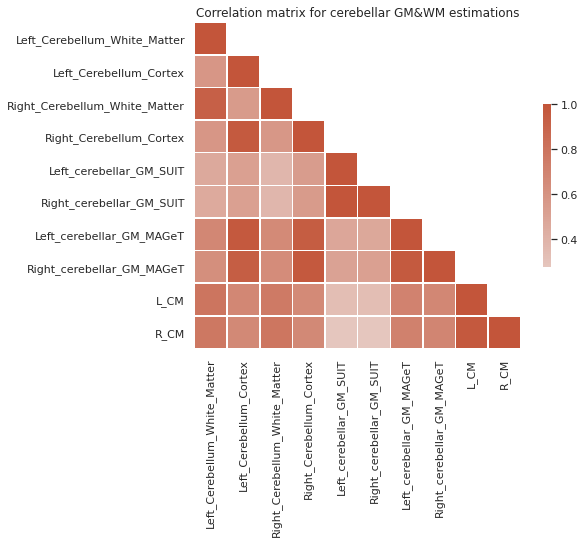

In [15]:
# Deprecated: report correlation between the intracranial volumes for controling
cere_list = ['eTIV', 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol'];

cerebellar_gm=matched_df.loc[:,freesurfer_cerebellar_list+suit_cerebellar_list+maget_cerebellar_list].copy();


sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Augmented dataset
corr_=cerebellar_gm.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for cerebellar GM&WM estimations')
display(corr_)